#### Predict numerical rise Voltage rise 
for the next period based on value of previous periods.


RNN created and trained in [VoltageRiseNum_Train](VoltageRiseNum_Train.ipynb)

---

#### Import modules to be used

In [117]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib
import ipyparallel as ipp


#### Import my own modules

In [5]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [20]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


In [14]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'


# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'


# Get files data 
p_mw_0013 = oriFc.readAndReshape_excelFile(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = oriFc.readAndReshape_excelFile(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = oriFc.readAndReshape_excelFile(file_p_inj_0100 ,excel_folder,)


p_mw_prod_bt_total = oriFc.readAndReshape_excelFile(file_prod_bt_total, excel_folder)
p_mw_cons_total = oriFc.readAndReshape_excelFile(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])


# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])
# Data cleaning on Consumption
previous_days = df_cons_total[(per_index>='2022 02 12') & (per_index<='2022 02 21 23:50')]
following_days = df_cons_total[(per_index>='2022 03 03') & (per_index<='2022 03 12 23:50')]
# # Put the interpolated data into the dataframe
df_cons_total[(per_index>='2022 02 21') & (per_index<='2022 03 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2


# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select relevant data up to 2022 06 01
df_prodHT = df_prodHT[df_prodHT.index<='2022 06 01 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2022 06 01 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2022 06 01 23:50']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('07:00','18:50') # for the persistance model, the previous period i.e. 06:50 
                                # is needed to compute the first instant i.e. 07:00
per_index = df_prodHT.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index>='2021 06 01']
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time('07:00','18:50') ).index.to_period('10T')


#### Data extraction on the network

In [15]:
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index 
                               if i in net_civaux_hv_bus.index]

# redefine data given final dataframe
df_prodHT = df_final[['P0013','P0018','P0100']] 
df_prod_bt_total = df_final[['Prod_BT']]
df_cons_total = df_final[['Cons']]

# Define a dict 
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Start Parallel engines

In [18]:
n_engines = 7  # Total number of engines
# (Use the real maximum cpu and not the logical)            
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

### No Control 

#### Send data into local space of each engine

In [21]:
# Import following modules on the local space of clients or engines
with rc[:].sync_imports(): 
    import numpy, pandapower, pandas, tqdm, par_oriFunctions
    
# Share the total number of simulation period among all the engines
dview.scatter('period',per_index)


# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = False 
parameters_dict = dict({'net_civaux':net_civaux, 
                 'net_civaux_hv_activated_bus':net_civaux_hv_activated_bus, 
                 'sum_max_main_network':sum_max_main_network, 
                 'dict_df_sgenLoad':dict_df_sgenLoad,  
                 'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client engine(s)

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing tqdm on engine(s)
importing Par_myFunctions on engine(s)


<AsyncResult(_push): pending>

#### Run power flow in each local engine

In [22]:
%%px 
resulting = [par_oriFunctions.run_powerflow_at(net_civaux, cur_period, net_civaux_hv_activated_bus, 
                                          sum_max_main_network, dict_df_sgenLoad, opf_status) for cur_period in period]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [23]:
# Gather the result of each engine in a sigle list
list_max_vm_pu = dview.gather('resulting')

#### Plot the maximum voltage on the network 

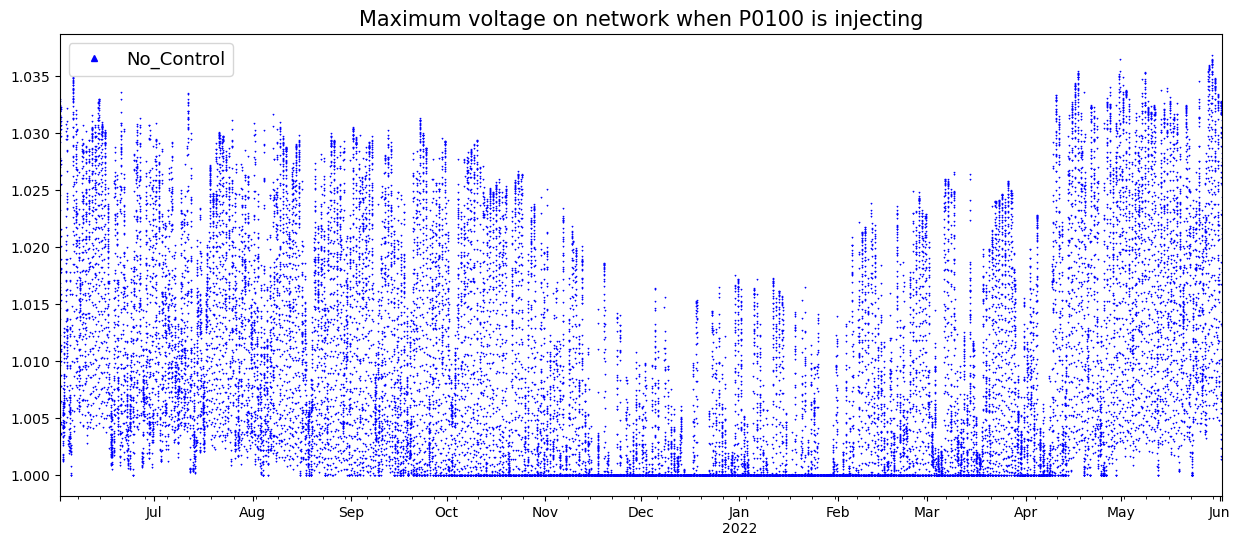

In [24]:
max_vm_pu_df = pd.DataFrame(data=list_max_vm_pu, index=per_index, columns=['No_Control'])
fig, axx = plt.subplots(figsize=(15,6))
max_vm_pu_df.plot(ax=axx, style='b^',markersize=0.5,)

plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network when P0100 is injecting", fontsize=15);
# plt.xlim(['2020 01 01', '2020 01 03'])

#### Import the numerical voltage rise prediction model i.e. Trained in [here](VoltageRiseNum_Train.ipynb)


In [30]:
# Import the voltage rise from 
numVriseModel = tf.keras.models.load_model('pickle_files/RNN/StLaurent_num_vRise_model')
scaler_train = joblib.load('pickle_files/RNN/StLaurent_num_vRise_scaler.plk')
scaler_features = joblib.load('pickle_files/RNN/StLaurent_num_vRise_scalerPred.plk')

### Set variables For numerical voltage rise prediction

In [74]:
# Create the dataframe to work with
working_df = df_final.copy(deep=True)

# add the voltage rise column to the working df
col_name = scaler_features.feature_names_in_[1] # Get the name that were used during the training process
working_df[col_name] = max_vm_pu_df.No_Control.values

#### Create dataset i.e. history that would be used to predict 

In [96]:
n_period = numVriseModel.input_shape[-1] # Get total number of periods or lags to 
                                         # consider to predict from the model to use
history = working_df.rolling(n_period)

hist_list = list(history)[n_period-1:] # Conveert %history in a list

len_hist = len(hist_list)

#### Run predictions

In [132]:
pred_per, pred = [],[]             
                
for hist_index in tqdm(range(len_hist)):
    cur_hist = hist_list[hist_index]          # current hystory
    # run prediction for each period 
    pred_var, pred_per_var = oriFc.prediction_bloc(rnn_model=numVriseModel, 
                                                fitting_scaler=scaler_train, 
                                                history=cur_hist, 
                                                scaler_features=scaler_features)
    
    pred_per.append(pred_per_var)
    pred.append(pred_var)
    


100%|██████████| 26347/26347 [17:20<00:00, 25.32it/s]


In [151]:
predicted_values = pd.DataFrame(data = np.array(pred).reshape((-1,2))[:,1],
                                index=pred_per, 
                                columns = ['V_rise_Pred'] )

per_index3 = ( pd.Series(index=predicted_values.index.to_timestamp(), dtype=object
                           ).between_time('08:00','18:50') ).index.to_period('10T')

### Scatter Plot Prediction vs Real values

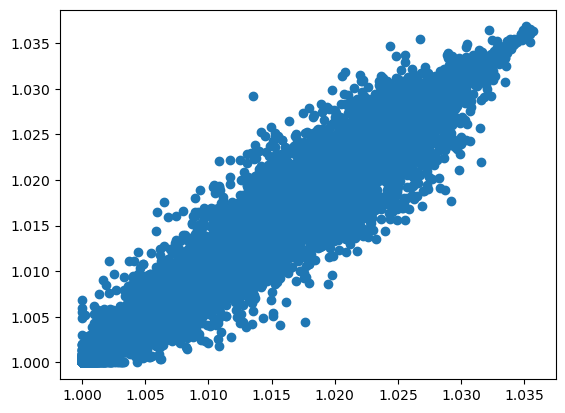

In [157]:
plt.scatter(predicted_values.loc[per_index3],working_df.loc[per_index3, ['Volt_Rise_num']])

In [ ]:
pd.Series((predicted_values.loc[per_index3]>vm_mu_max).values.reshape(-1)).value_counts()

False    21922
True      2234
dtype: int64

In [ ]:
pd.Series((working_df.loc[per_index3, ['Volt_Rise_num']]>vm_mu_max).values.reshape(-1)).value_counts()

False    21608
True      2548
dtype: int64

In [189]:
joblib.dump(predicted_values, 'pickle_files/simulationResults/Numerical_Voltage_Rise_Predicted.pkl',)

['pickle_files/simulationResults/Numerical_Voltage_Rise_Predicted.pkl']

---